   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.2 MB/s eta 0:00:00


Saving out.moreno_oz_oz.docx to out.moreno_oz_oz.docx
Graph has 217 nodes and 1839 edges.
Sample edges with weights:
(1, 2, {'weight': 3.5})
(1, 3, {'weight': 4.5})
(1, 4, {'weight': 3.5})
(1, 5, {'weight': 4.0})
(1, 6, {'weight': 3.5})
Vaccination Fraction 0: LCC = 217, TI = 2062, IP = 166
Vaccination Fraction 0.08: LCC = 200, TI = 1855, IP = 148
Vaccination Fraction 0.16: LCC = 183, TI = 1811, IP = 129
Vaccination Fraction 0.24: LCC = 165, TI = 1283, IP = 107


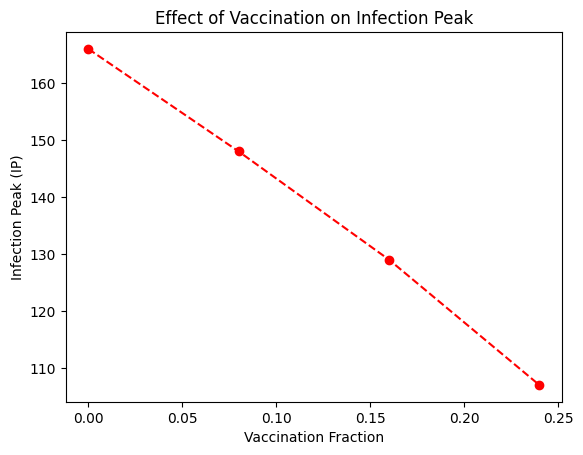

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from google.colab import files
!pip install python-docx
import docx

uploaded = files.upload()
file_name = list(uploaded.keys())[0]

doc = docx.Document(file_name)
edges = []
for paragraph in doc.paragraphs:
    try:
        line = paragraph.text
        if not line.startswith('%'):
            source, target, weight = line.strip().split()
            edges.append([int(source), int(target), float(weight)])
    except ValueError:
        pass

G_directed = nx.DiGraph()
for edge in edges:
    source, target, weight = edge
    G_directed.add_edge(source, target, weight=weight)

# Convert to an undirected graph by averaging edge weights
G_undirected = nx.Graph()
for u, v, data in G_directed.edges(data=True):
    weight = data["weight"]
    if G_undirected.has_edge(u, v):
        G_undirected[u][v]["weight"] = (G_undirected[u][v]["weight"] + weight) / 2
    else:
        G_undirected.add_edge(u, v, weight=weight)

# Print basic network info
print(f"Graph has {G_undirected.number_of_nodes()} nodes and {G_undirected.number_of_edges()} edges.")

# Display a few edges to verify weight averaging
print("Sample edges with weights:")
for edge in list(G_undirected.edges(data=True))[:5]:
    print(edge)

# Function to remove nodes based on degree
def remove_nodes_by_degree(G, fraction):
    """Removes a fraction of nodes with the highest degree."""
    G_copy = G.copy()
    num_remove = int(fraction * G.number_of_nodes())
    nodes_sorted = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    nodes_to_remove = [node for node, _ in nodes_sorted[:num_remove]]
    G_copy.remove_nodes_from(nodes_to_remove)
    return G_copy

# Function to simulate SIR epidemic model
def simulate_SIR(G, initial_fraction=0.01, beta=0.3, gamma=0.1, steps=50):
    """Simulates SIR epidemic model and returns total infected (TI) and infection peak (IP)."""
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()

    nodes = list(G_lcc.nodes())
    initial_infected = set(random.sample(nodes, int(initial_fraction * len(nodes))))
    susceptible = set(nodes) - initial_infected
    infected = initial_infected.copy()
    recovered = set()
    infection_counts = []

    for _ in range(steps):
        new_infected = set()
        for node in infected:
            for neighbor in G_lcc.neighbors(node):
                if neighbor in susceptible and random.random() < beta:
                    new_infected.add(neighbor)

        infected |= new_infected
        susceptible -= new_infected
        recovered |= {node for node in infected if random.random() < gamma}

        infected -= recovered
        infection_counts.append(len(infected))

    return sum(infection_counts), max(infection_counts)

vaccination_fractions = [0, 0.08, 0.16, 0.24]
infection_peaks = []

for f in vaccination_fractions:
    G_vac = remove_nodes_by_degree(G_undirected, f)
    LCC_nodes = max(nx.connected_components(G_vac), key=len)
    G_LCC = G_vac.subgraph(LCC_nodes).copy()

    total_infected, infection_peak = simulate_SIR(G_LCC)
    infection_peaks.append(infection_peak)

    print(f"Vaccination Fraction {f}: LCC = {len(G_LCC.nodes())}, TI = {total_infected}, IP = {infection_peak}")


plt.plot(vaccination_fractions, infection_peaks, marker='o', linestyle='--', color='r')
plt.xlabel("Vaccination Fraction")
plt.ylabel("Infection Peak (IP)")
plt.title("Effect of Vaccination on Infection Peak")
plt.show()

Simulation results saved to simulation_results.json


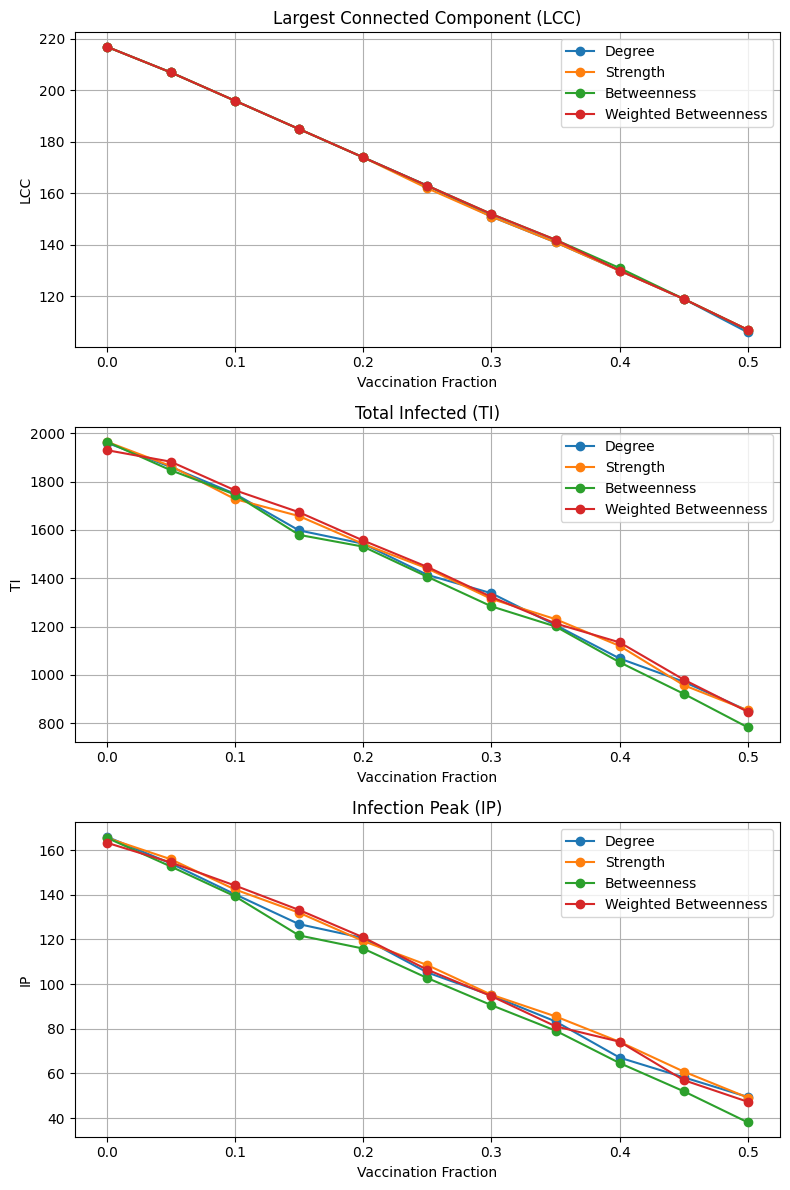

In [3]:
import json
vaccination_fractions = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
num_iterations = 100  # Increased to 100 iterations

def vaccinate(G, fraction, centrality):
    G_copy = G.copy()
    num_remove = int(len(G.nodes) * fraction)
    nodes_sorted = sorted(centrality, key=centrality.get, reverse=True)
    nodes_to_remove = nodes_sorted[:num_remove]
    G_copy.remove_nodes_from(nodes_to_remove)
    return G_copy

# Compute different centrality measures
degree_centrality = dict(G_undirected.degree())
strength_centrality = {node: sum(G_undirected[node][nbr].get("weight", 1) for nbr in G_undirected.neighbors(node)) for node in G_undirected}
betweenness_centrality = nx.betweenness_centrality(G_undirected, normalized=True)

# Compute Weighted Betweenness Centrality
inverse_weights = {(u, v): 1 / data["weight"] if data["weight"] > 0 else 1.0 for u, v, data in G_undirected.edges(data=True)}
nx.set_edge_attributes(G_undirected, inverse_weights, "inverse_weight")
weighted_betweenness_centrality = nx.betweenness_centrality(G_undirected, weight="inverse_weight")

strategies = {
    "Degree": degree_centrality,
    "Strength": strength_centrality,
    "Betweenness": betweenness_centrality,
    "Weighted Betweenness": weighted_betweenness_centrality
}

results = {s: {"LCC": [], "TI": [], "IP": []} for s in strategies}
for strategy, centrality in strategies.items():
    for fraction in vaccination_fractions:
        LCC_vals, TI_vals, IP_vals = [], [], []

        for _ in range(num_iterations):
            G_vac = vaccinate(G_undirected, fraction, centrality)
            LCC_nodes = max(nx.connected_components(G_vac), key=len)
            G_LCC = G_vac.subgraph(LCC_nodes).copy()

            total_infected, infection_peak = simulate_SIR(G_LCC, steps=100)
            LCC_vals.append(len(G_LCC.nodes()))
            TI_vals.append(total_infected)
            IP_vals.append(infection_peak)

        # Store the average values
        results[strategy]["LCC"].append(sum(LCC_vals) / num_iterations)
        results[strategy]["TI"].append(sum(TI_vals) / num_iterations)
        results[strategy]["IP"].append(sum(IP_vals) / num_iterations)

# Save results to JSON for future analysis
with open("simulation_results.json", "w") as f:
    json.dump(results, f)

print("Simulation results saved to simulation_results.json")

# Plot Results
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
metrics = ["LCC", "TI", "IP"]
titles = ["Largest Connected Component (LCC)", "Total Infected (TI)", "Infection Peak (IP)"]

for i, metric in enumerate(metrics):
    ax = axes[i]
    for strategy in strategies:
        ax.plot(vaccination_fractions, results[strategy][metric], marker='o', label=strategy)
    ax.set_title(titles[i])
    ax.set_xlabel("Vaccination Fraction")
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()